# Recreating Pixel Maps with static pixels in percentile bins

In [48]:
%matplotlib inline

from matplotlib.pyplot import subplots, savefig
import richardsplot as rplot

from utilities.analysis import plotting
from utilities.ccd import CCD
from utilities.containers import *
from utilities.conversions import magToFlux

In [49]:
cmap = rplot.palettable.colorbrewer.diverging.PuOr_11.mpl_colormap

In [3]:
!pwd
!mkdir plots/c08/

/home/jackeline/Research/k2_pipeline/CARMA
mkdir: cannot create directory ‘plots/c08/’: File exists


# Load Data hdf5 file --example using C8 M10.1

In [50]:
pixmapfile = "/media/jackeline/UUI/PixelMaps/K2_target_pixels.hdf5"

#  Run the Pixel Map Generator

In [51]:
ccd = CCD(module=10, channel=1, field='FLUX', campaign=8)
cont = PixelMapContainer.from_hdf5(pixmapfile, ccd)
cont.save(pixmapfile)
gen = PixMapGenerator(cont)
print "Making", ccd
            

  Writing... (Do Not Turn off Device or Stop Kernel)

Making CCD(module=10, channel=1, field='FLUX', campaign=8)


# tracking pixels

In [67]:
from itertools import izip, imap, ifilter
import numpy as np

def test_pixel_lc(gen,percentiles, flux_range=None, stat_funcs=None):
    if flux_range is not None:
        lower, higher = sorted(flux_range)

    if stat_funcs is None:
        stat_funcs = (np.median,)

    ccd = gen.ccd
    N = gen.N
    M = len(percentiles)-1
    L = len(stat_funcs)

    lc = np.empty((N, M, L+2))
    lc[::] = np.nan


    l_bin_edges = np.empty((gen.N, len(percentiles)))
    def _get_epochs():

        if flux_range is not None:
            return _get_filtered_epochs()

        return _get_full_epochs()

    def _get_full_epochs():

        for i, g in enumerate(imap(gen.get_unordered, xrange(gen.N))):

                yield g

    def _get_filtered_epochs():

        for i, g in enumerate(imap(gen.get_unordered, xrange(gen.N))):

            mask = (g > lower) & (g < higher)
            yield g[mask]
    
    pixel_median_flux = []
    allpixel = []
    for i in range(len(gen.containers.containers[:])):
        pix_t_index = np.shape(gen.containers.containers[i].pixels)[0]
        pix_row = np.shape(gen.containers.containers[i].pixels)[1]
        pix_column = np.shape(gen.containers.containers[i].pixels)[2]

        for r in range (pix_row):
            for c in range (pix_column):
                fluxes = gen.containers.containers[i].pixels[:,r,c]
                #stack all pixels all at epoch = l index 
                allpixel.append(fluxes)


                mask = (fluxes > lower) & (fluxes < higher)
                pixel_median_flux.append([r,c,np.nanmedian(fluxes[mask])])
            
    print("computed median fluxes for %d pixels" %len(pixel_median_flux))    
    #remove neg flux pixels and nans
    keep = np.where((np.array(pixel_median_flux)[:,2])>0)[0] 
    print('Removing %d pixels due to negative flux or NANs' %(len(pixel_median_flux)-len(keep)))
    #assign pixel a percentile based on median
    percentile_bin_edges = np.nanpercentile(np.array(pixel_median_flux)[keep,2], percentiles, axis=0).T
    percentile_bin_edges[-1]  += 1e-10 
    indices = np.digitize(np.array(pixel_median_flux)[keep,2], percentile_bin_edges)-1 
    print('%d indices are negative and %d indices are greater than 499 '%(len(indices[indices < 0 ]), len(indices[indices > 499 ])))
    # y is a pixel stack for the current epoch, y is updated for each iteration over the outer loop-l            
    pixel_data = np.array(allpixel)[keep]
    print("pixeldata shape ")
    print(np.shape(pixel_data))
    #lengths = np.array(map(len, epochs))
    #unique_lengths = np.unique(lengths[lengths!=0])
    

    #lc[:,:,0] = l_bin_edges[:-1]
    #lc[:,:,1] = l_bin_edges[1:]
    epochs = list(_get_epochs())
    print("epoch shape ")
    print(np.shape(np.array(epochs)))
    lengths = np.array(map(len, epochs))
    unique_lengths = np.unique(lengths[lengths!=0])

    for length in unique_lengths:

        l_index = np.where(lengths == length)[0]
        
        
        
        #checl y and epoch have the same dimenions
        l_uniform_array = np.asarray([pixel_data[:,i] for i in l_index]) 
        #l_uniform_array = np.asarray([epochs[i] for i in l_index]) 

        print("l_index ")
        print(l_index)
        print('epochs[i]') 
        print(np.shape(l_uniform_array))
        l_bin_edges[l_index] = np.percentile(l_uniform_array, percentiles, axis=1).T
        l_bin_edges[l_index,-1] += 1e-10

        lc[l_index,:,0] = l_bin_edges[l_index,:-1]
        lc[l_index,:,1] = l_bin_edges[l_index,1:]	
    

        #outer loop over each epoch  (time step)  
        for l, y in izip(l_index, l_uniform_array):

            # y is a pixel stack for the current epoch, y is updated for each iteration over the outer loop-l            
            #y = np.array(allpixel)[keep]

            #calculated the number of non-zero percentile bins
            bin_counts = np.bincount(indices) # try to arrange arrays so that we can compute stats in parallel
            same_counts = np.unique(bin_counts[bin_counts!=0])

            #compute value of each percentile bin for current epoch
            for count in same_counts:

                index = np.where(bin_counts == count)[0]
                uniform_array = np.asarray([y[i==indices] for i in index])

                lc[l,index, 2:] = np.array([stat_func(uniform_array, axis=1) for stat_func in stat_funcs]).T
    return lc
        

In [68]:
percentiles = np.linspace(0, 100, 501)
flux_range = map(magToFlux,(50,1))
lc = test_pixel_lc(gen,percentiles, flux_range = flux_range)


/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
/home/jackeline/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


computed median fluxes for 23530 pixels
Removing 516 pixels due to negative flux or NANs
0 indices are negative and 0 indices are greater than 499 
pixeldata shape 
(23014, 3853)
epoch shape 
(3853,)
l_index 
[3847]
epochs[i]
(1, 23014)
l_index 
[3750]
epochs[i]
(1, 23014)
l_index 
[3836]
epochs[i]
(1, 23014)
l_index 
[3848]
epochs[i]
(1, 23014)
l_index 
[3781]
epochs[i]
(1, 23014)
l_index 
[3846]
epochs[i]
(1, 23014)
l_index 
[3759]
epochs[i]
(1, 23014)
l_index 
[3756]
epochs[i]
(1, 23014)
l_index 
[3794]
epochs[i]
(1, 23014)
l_index 
[3782]
epochs[i]
(1, 23014)
l_index 
[3797]
epochs[i]
(1, 23014)
l_index 
[3834]
epochs[i]
(1, 23014)
l_index 
[3844]
epochs[i]
(1, 23014)
l_index 
[3727]
epochs[i]
(1, 23014)
l_index 
[3761]
epochs[i]
(1, 23014)
l_index 
[3811]
epochs[i]
(1, 23014)
l_index 
[3768]
epochs[i]
(1, 23014)
l_index 
[3754 3755]
epochs[i]
(2, 23014)
l_index 
[3747 3757]
epochs[i]
(2, 23014)
l_index 
[3808]
epochs[i]
(1, 23014)
l_index 
[3719 3821]
epochs[i]
(2, 23014)
l_index 

l_index 
[3392 3521]
epochs[i]
(2, 23014)
l_index 
[2848]
epochs[i]
(1, 23014)
l_index 
[3510 3522 3546 3631]
epochs[i]
(4, 23014)
l_index 
[3566]
epochs[i]
(1, 23014)
l_index 
[3394 3398 3536]
epochs[i]
(3, 23014)
l_index 
[3341 3629 3630]
epochs[i]
(3, 23014)
l_index 
[2764]
epochs[i]
(1, 23014)
l_index 
[3608 3633]
epochs[i]
(2, 23014)
l_index 
[3481]
epochs[i]
(1, 23014)
l_index 
[3472]
epochs[i]
(1, 23014)
l_index 
[3335 3507]
epochs[i]
(2, 23014)
l_index 
[3444 3454 3505 3529]
epochs[i]
(4, 23014)
l_index 
[3260 3478 3520]
epochs[i]
(3, 23014)
l_index 
[3669]
epochs[i]
(1, 23014)
l_index 
[3508 3516 3550 3609]
epochs[i]
(4, 23014)
l_index 
[3469 3565 3594]
epochs[i]
(3, 23014)
l_index 
[2763 3497]
epochs[i]
(2, 23014)
l_index 
[2756]
epochs[i]
(1, 23014)
l_index 
[3426 3467 3468]
epochs[i]
(3, 23014)
l_index 
[3486 3503]
epochs[i]
(2, 23014)
l_index 
[3612 3617]
epochs[i]
(2, 23014)
l_index 
[3535]
epochs[i]
(1, 23014)
l_index 
[3527]
epochs[i]
(1, 23014)
l_index 
[3447]
epochs[i

l_index 
[2759]
epochs[i]
(1, 23014)
l_index 
[2605 2791]
epochs[i]
(2, 23014)
l_index 
[2665 2716 2857 2907]
epochs[i]
(4, 23014)
l_index 
[2536]
epochs[i]
(1, 23014)
l_index 
[2706]
epochs[i]
(1, 23014)
l_index 
[2844 3138]
epochs[i]
(2, 23014)
l_index 
[2542 2875 2899 3103 3242 3295]
epochs[i]
(6, 23014)
l_index 
[2734 2774 2795 2858 2874 3186]
epochs[i]
(6, 23014)
l_index 
[2631]
epochs[i]
(1, 23014)
l_index 
[2596 2702 2908]
epochs[i]
(3, 23014)
l_index 
[2576 2713 2861]
epochs[i]
(3, 23014)
l_index 
[2688 2744]
epochs[i]
(2, 23014)
l_index 
[2655 2859 2957 3140]
epochs[i]
(4, 23014)
l_index 
[2643 2854 3311]
epochs[i]
(3, 23014)
l_index 
[2720 3243]
epochs[i]
(2, 23014)
l_index 
[2483 2646 2678 2960]
epochs[i]
(4, 23014)
l_index 
[2608 2710 2832 3281]
epochs[i]
(4, 23014)
l_index 
[2583 2717]
epochs[i]
(2, 23014)
l_index 
[2447 2651 2819]
epochs[i]
(3, 23014)
l_index 
[3184]
epochs[i]
(1, 23014)
l_index 
[2807 3288]
epochs[i]
(2, 23014)
l_index 
[2782 2941]
epochs[i]
(2, 23014)
l

l_index 
[2505 2575 2866 3233]
epochs[i]
(4, 23014)
l_index 
[2311 2893 2933 3122 3149]
epochs[i]
(5, 23014)
l_index 
[1422 2416 3110 3118]
epochs[i]
(4, 23014)
l_index 
[2236 2250]
epochs[i]
(2, 23014)
l_index 
[  43 2261 2407 3083 3227]
epochs[i]
(5, 23014)
l_index 
[2495 3017]
epochs[i]
(2, 23014)
l_index 
[2932 3146 3192 3196]
epochs[i]
(4, 23014)
l_index 
[2317 2491 2705 3012 3173]
epochs[i]
(5, 23014)
l_index 
[1420 2164 2961 3171 3198]
epochs[i]
(5, 23014)
l_index 
[2271 2399 3226]
epochs[i]
(3, 23014)
l_index 
[2124 2133 2202]
epochs[i]
(3, 23014)
l_index 
[  41 2215 2438 2467 3032]
epochs[i]
(5, 23014)
l_index 
[1410 2221 2242 2262 2340 2771 2878]
epochs[i]
(7, 23014)
l_index 
[2143 2992 3096]
epochs[i]
(3, 23014)
l_index 
[  78 3065]
epochs[i]
(2, 23014)
l_index 
[2299 2468 2499 2577]
epochs[i]
(4, 23014)
l_index 
[2239 2510 2975 3180]
epochs[i]
(4, 23014)
l_index 
[1412 2184 2270 2370 2952]
epochs[i]
(5, 23014)
l_index 
[2170 3043]
epochs[i]
(2, 23014)
l_index 
[1406 2132 23

l_index 
[594]
epochs[i]
(1, 23014)
l_index 
[ 116  136  174 2060]
epochs[i]
(4, 23014)
l_index 
[ 367 2162]
epochs[i]
(2, 23014)
l_index 
[ 810 1396 1962 1967 2071]
epochs[i]
(5, 23014)
l_index 
[ 368 1947 2008]
epochs[i]
(3, 23014)
l_index 
[2031 2065 2155]
epochs[i]
(3, 23014)
l_index 
[ 476 1404 2054 3057]
epochs[i]
(4, 23014)
l_index 
[ 329  775 1577]
epochs[i]
(3, 23014)
l_index 
[1486 1661 1842 2083 2265]
epochs[i]
(5, 23014)
l_index 
[ 173  293  311 2021 2107 2541]
epochs[i]
(6, 23014)
l_index 
[ 102 1491 1614]
epochs[i]
(3, 23014)
l_index 
[1607 1948]
epochs[i]
(2, 23014)
l_index 
[ 533  680 1571 2038]
epochs[i]
(4, 23014)
l_index 
[ 243 2318 2501]
epochs[i]
(3, 23014)
l_index 
[ 306  790 1851 3117]
epochs[i]
(4, 23014)
l_index 
[  82 1376 1896 1921]
epochs[i]
(4, 23014)
l_index 
[   6  272 2027]
epochs[i]
(3, 23014)
l_index 
[ 267 1659 1757 3033]
epochs[i]
(4, 23014)
l_index 
[   8 1335 1930 1935 2010 2066 2172 2949]
epochs[i]
(8, 23014)
l_index 
[1210 1413 1617 2041]
epochs[

l_index 
[ 359 1447 1541 1636 2985]
epochs[i]
(5, 23014)
l_index 
[ 182  300 1201 1213 1640]
epochs[i]
(5, 23014)
l_index 
[  96  627 1740 1905 1974]
epochs[i]
(5, 23014)
l_index 
[  33  857  878 1155 1250 1300 1360 1390 1513 1650 1673]
epochs[i]
(11, 23014)
l_index 
[ 156  281  436  889 1205 1553]
epochs[i]
(6, 23014)
l_index 
[  22  485  565 1042 1211 1981]
epochs[i]
(6, 23014)
l_index 
[  99  184  879 1002 1107 1118 1188]
epochs[i]
(7, 23014)
l_index 
[ 277  304  470  842 1105 1244 1539 1803 1812 1911]
epochs[i]
(10, 23014)
l_index 
[ 167 1345 1630 1699]
epochs[i]
(4, 23014)
l_index 
[ 596  613 1016 1131 1485]
epochs[i]
(5, 23014)
l_index 
[  86  234  456  639  733 1004 1526 1880 1892 1975]
epochs[i]
(10, 23014)
l_index 
[  37  185  315  337  601 1762 1844 1874]
epochs[i]
(8, 23014)
l_index 
[1066 1394 1603 1808]
epochs[i]
(4, 23014)
l_index 
[ 623  768 1466 1551]
epochs[i]
(4, 23014)
l_index 
[ 568  801  848 1099 1446 1531 1584]
epochs[i]
(7, 23014)
l_index 
[1690 1751 1837]
epochs

l_index 
[ 606  809  828  929 1059 1240 1782]
epochs[i]
(7, 23014)
l_index 
[ 261  558 1025]
epochs[i]
(3, 23014)
l_index 
[ 527 1051 1054]
epochs[i]
(3, 23014)
l_index 
[ 149  221 1127]
epochs[i]
(3, 23014)
l_index 
[ 466  496  629  709 1666]
epochs[i]
(5, 23014)
l_index 
[ 701  899  900 1178 1232]
epochs[i]
(5, 23014)
l_index 
[ 744 1020 1074]
epochs[i]
(3, 23014)
l_index 
[ 171  917  930 1071 1679]
epochs[i]
(5, 23014)
l_index 
[1040 1180]
epochs[i]
(2, 23014)
l_index 
[106 206 230 486 835]
epochs[i]
(5, 23014)
l_index 
[ 211  422 1760]
epochs[i]
(3, 23014)
l_index 
[ 406 1106 1989]
epochs[i]
(3, 23014)
l_index 
[458 672 745 980]
epochs[i]
(4, 23014)
l_index 
[345 673]
epochs[i]
(2, 23014)
l_index 
[ 491  625  830  908  912 1057]
epochs[i]
(6, 23014)
l_index 
[ 513  597 1091]
epochs[i]
(3, 23014)
l_index 
[ 539 1024]
epochs[i]
(2, 23014)
l_index 
[ 519 1120]
epochs[i]
(2, 23014)
l_index 
[402 706 927]
epochs[i]
(3, 23014)
l_index 
[389 497 508 540]
epochs[i]
(4, 23014)
l_index 
[ 15

# Plot CCD Pixel Map

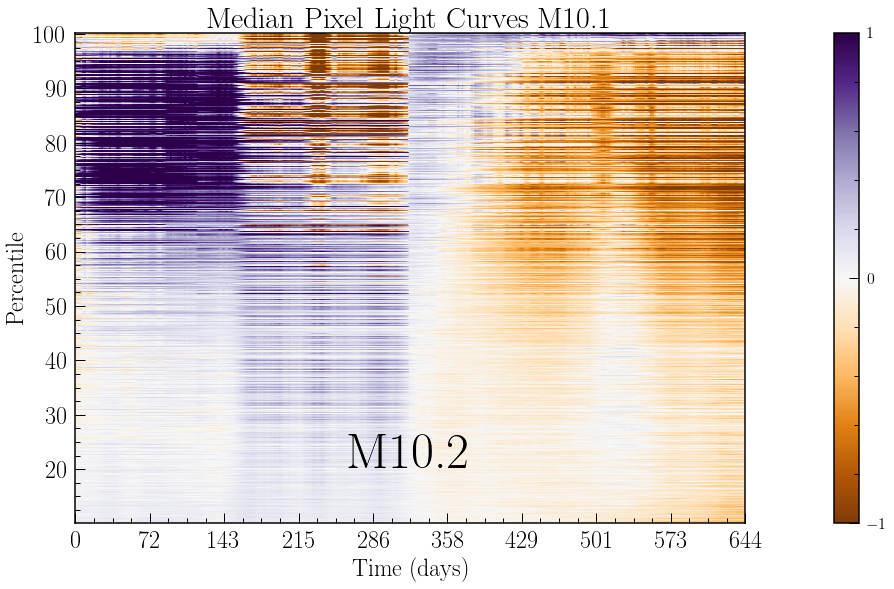

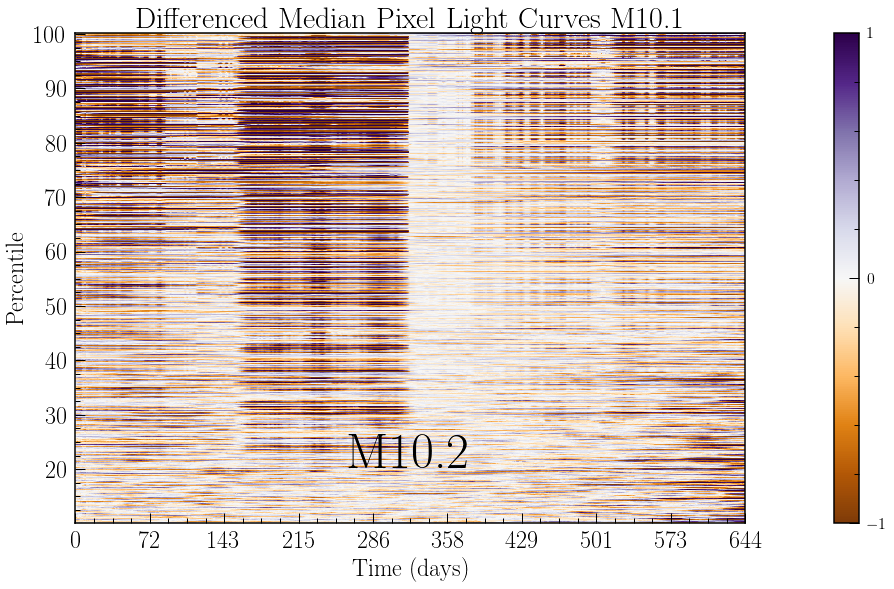

In [69]:
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc[:,:,2], smooth=120, image=True,
                          aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc.shape[0])
ax.set_title("Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapFull.png'.format(ccd.campaign, ccd.module, ccd.channel))
    
#Make the differenced image map
fig, ax = subplots(1,1, figsize=(16,9))
im = plotting.plot_pixel_lc(ax, lc[:,:,2], smooth=120, image=True,
                          differenced=True, aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plotting.format_pixel_image(ax, im, lc.shape[0])
ax.set_title("Differenced Median Pixel Light Curves M{}.{}".format(ccd.module, ccd.channel),
                fontsize=30)
ax.plot(0, 0, "-", label="M{}.{}".format(ccd.module, ccd.channel+1))    
ax.legend(fontsize = 50, frameon=False, loc = 8, handlelength=0, handletextpad=0,)
savefig('plots/c{:02d}/Module{}Channel{}PixelMapDiff.png'.format(ccd.campaign, ccd.module, ccd.channel))
    

# Debugging

In [71]:
    pixel_median_flux = []
    allpixel = []
    for i in range(len(gen.containers.containers[:])):
        pix_t_index = np.shape(gen.containers.containers[i].pixels)[0]
        pix_row = np.shape(gen.containers.containers[i].pixels)[1]
        pix_column = np.shape(gen.containers.containers[i].pixels)[2]

        for r in range (pix_row):
            for c in range (pix_column):
                fluxes = gen.containers.containers[i].pixels[:,r,c]
                #stack all pixels all at epoch = l index 
                allpixel.append(fluxes)


                #mask = (fluxes > lower) & (fluxes < higher)
                pixel_median_flux.append([r,c,np.nanmedian(fluxes)])
            
    print("computed median fluxes for %d pixels" %len(pixel_median_flux))    
    #remove neg flux pixels and nans
    keep = np.where((np.array(pixel_median_flux)[:,2])>0)[0] 
    print('Removing %d pixels due to negative flux or NANs' %(len(pixel_median_flux)-len(keep)))
    #assign pixel a percentile based on median
    percentile_bin_edges = np.nanpercentile(np.array(pixel_median_flux)[keep,2], percentiles, axis=0).T
    percentile_bin_edges[-1]  += 1e-10 
    indices = np.digitize(np.array(pixel_median_flux)[keep,2], percentile_bin_edges)-1 
    print('%d indices are negative and %d indices are greater than 499 '%(len(indices[indices < 0 ]), len(indices[indices > 499 ])))
    # y is a pixel stack for the current epoch, y is updated for each iteration over the outer loop-l            
    pixel_data = np.array(allpixel)[keep]
    print("pixeldata shape ")
    print(np.shape(pixel_data))

computed median fluxes for 23530 pixels
Removing 3363 pixels due to negative flux or NANs
0 indices are negative and 0 indices are greater than 499 
pixeldata shape 
(20167, 3853)


In [31]:
keep = np.where((np.array(pixel_median_flux)[:,2])>0)[0] 

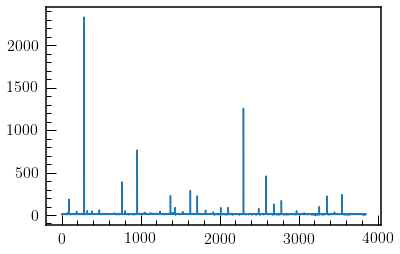

In [78]:
import matplotlib.pyplot as plt
plt.plot(xrange(3853),pixel_data[100,:])